# Data Access 
## Where does all the data we've taken go?
## How do I ask questions of it?

#### Yusra AlSayyad
#### October 11 2024


We'll introduce:
* Where to find the raws and processed images (cmdline, notebook)
* What pipelines run where
* Accessing and displaying images from the butler
* EFD data
* Timesquare

We'll follow a photon through data management.

We've taken an exposure with Auxtel and read out an image. 

That image gets ingested into the **summit butler**.
At this point it has the **datasetType** called `raw`.

A copy of this `raw` also is sent accross the *long haul network* to the USDF at SLAC, and is ingested into the **usdf butler**

In [1]:
from lsst.daf.butler import Butler

butler = Butler("embargo_old") # <-- how do we find repos 
# butler.get(?, collections=?) # how do we know datasetType names and collections?


First some background which is described in graphical form: [slides](https://docs.google.com/presentation/d/1oq7lff8kfW334HkEY04GXPbXlv83Se48fh7anpcwWBM/edit?usp=sharing)

In [2]:
butler = Butler("embargo_old")
for collection in sorted(butler.registry.queryCollections("LATISS/runs/*"))[0:10]:
    print(collection)

LATISS/runs/AUXTEL_BIAS/w_2024_07/PREOPS-4881
LATISS/runs/AUXTEL_BIAS/w_2024_07/PREOPS-4881/20240220T224231Z
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2023_47/PREOPS-4615
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2023_47/PREOPS-4615/20231129T210902Z
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2023_47/PREOPS-4615/20231129T232656Z
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2024_15/PREOPS-5076
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2024_15/PREOPS-5076/20240419T161711Z
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2024_30/PREOPS-5368
LATISS/runs/AUXTEL_CWFS_FOCUS_SWEEP/w_2024_30/PREOPS-5368/20240814T200904Z
LATISS/runs/AUXTEL_DARK/w_2024_07/PREOPS-4881


In [3]:
# This would list every collection

#for c in sorted(butler.collections.query('*')):
#    print(c)

In the `notebooks/tutorial-notebooks` folder you'll find example notebooks:

* `notebooks/tutorial-notebooks/DP02_04a_Introduction_to_the_Butler.ipynb`
* `notebooks/tutorial-notebooks/DP02_04b_Intermediate_Butler_Queries.ipynb`

have many more examples for querying the butler

# Image display

### Create a Display

To display images you will use the LSST `afwDisplay` framework. It provides a uniform API for multiple display backends, including DS9, matplotlib, and LSST’s Firefly viewer. The default backend is `ds9`, but since we are working remotely on `jupyterhub` we would prefer to use the web-based Firefly display. A [user guide](https://pipelines.lsst.io/v/daily/modules/lsst.display.firefly/index.html)  for `lsst.display.firefly` is available on the [pipelines.lsst.io site](https://pipelines.lsst.io/v/daily).

In [4]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')
display1 = afwDisplay.Display(frame=1)
display1.getClient().get_firefly_url()

'https://usdf-rsp.slac.stanford.edu/portal/app/?__wsch=ffChan-yusra-nb-1728598791-53'

In [5]:
# grab a LSSTComCamSim raw from Ops Rehearsal 4
butler = Butler("embargo_new", 
                collections="LSSTComCamSim/runs/nightlyValidation/20240627/w_2024_25/DM-44966")
raw = butler.get("raw", day_obs=20240627, seq_num=300, 
                 detector=0, instrument="LSSTComCamSim")
display1.mtv(raw)

In [6]:
# raw -> ||-isrTask-|| -> postISRCCD

dataId = {"day_obs": 20240627, 
          "seq_num": 300, 
          "detector": 0, 
          "instrument": "LSSTComCamSim"}

postISRCCD = butler.get("postISRCCD", dataId=dataId)
display1.mtv(postISRCCD)

In [7]:
# postISRCCD -> ||-characterizeimage-|| -> ||calibrate|| -> calexp

# Warning! Before ComCam onsky, this will become:
#  postISRCCD -> ||calibrateImage|| -> initial_pvi

calexp = butler.get("calexp", dataId=dataId)
                    
display1.mtv(calexp)

In [8]:
psf = calexp.psf
wcs = calexp.wcs
photoCalib = calexp.photoCalib
# backgrounds are stored separately:
bkgd = butler.get('calexpBackground', dataId=dataId)

In [9]:
# Compute the FWHM at the center of the detector:
import numpy as np
SIGMA2FWHM = np.sqrt(8 * np.log(2))
pixels2Arcseconds = wcs.getPixelScale(calexp.getBBox().getCenter()).asArcseconds() 

shape = psf.computeShape(calexp.getBBox().getCenter())
shape.getDeterminantRadius() * pixels2Arcseconds * SIGMA2FWHM

0.6454849183360134

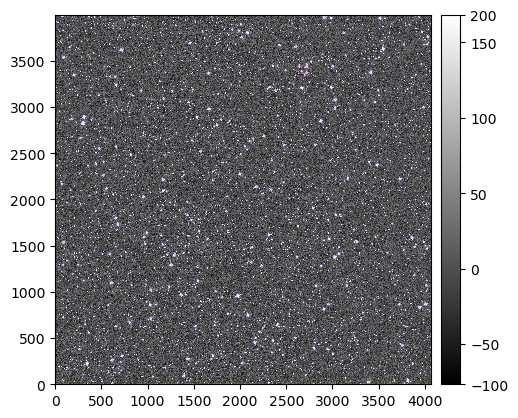

In [10]:
# We can also display it in matplotlib:

display2 = afwDisplay.Display(frame=1, backend='matplotlib')
display2.setMaskTransparency(90)
display2.scale("linear", "zscale")
display2.mtv(calexp)

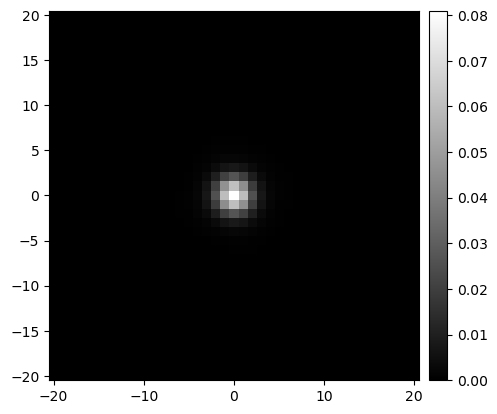

In [11]:
# And display the PSF Model:

display2 = afwDisplay.Display(frame=1, backend='matplotlib')
display2.setMaskTransparency(90)
display2.mtv(psf.computeKernelImage(calexp.getBBox().getCenter()))

-7.545979769929545e-06 0.00013672302884515375


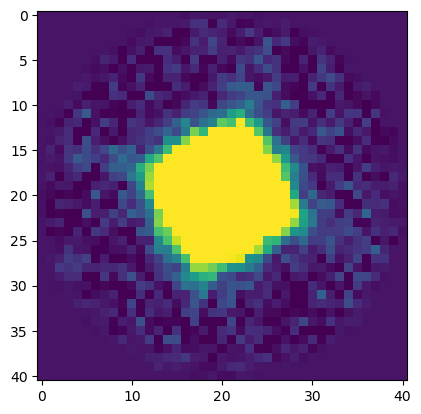

In [12]:
import matplotlib.pyplot as plt
array = psf.computeKernelImage(calexp.getBBox().getCenter()).array
vmin, vmax = np.percentile(array, (10, 90))
print(vmin, vmax)
plt.imshow(array, vmin=vmin, vmax=vmax)
plt.show()

### How about LATISS?

In [13]:
LATISS_DEFAULT_COLLECTIONS = ["LATISS/raw/all", "LATISS/calib"]
butler = Butler("embargo_old", collections=LATISS_DEFAULT_COLLECTIONS)

where = f"exposure.day_obs=20240910 AND instrument='LATISS'"
records = list(butler.registry.queryDimensionRecords('exposure', where=where))
records = sorted(records, key=lambda x: (x.day_obs, x.seq_num))
print(f'Found {len(records)} records from {len(set(r.day_obs for r in records))} days')

Found 457 records from 1 days


In [14]:
LATISS_DEFAULT_COLLECTIONS = ["LATISS/raw/all", "LATISS/calib", "LATISS/runs/quickLook"]
butler = Butler("embargo_old", collections=LATISS_DEFAULT_COLLECTIONS)
raw = butler.get("raw", day_obs=20240910, seq_num=460, detector=0, instrument="LATISS")

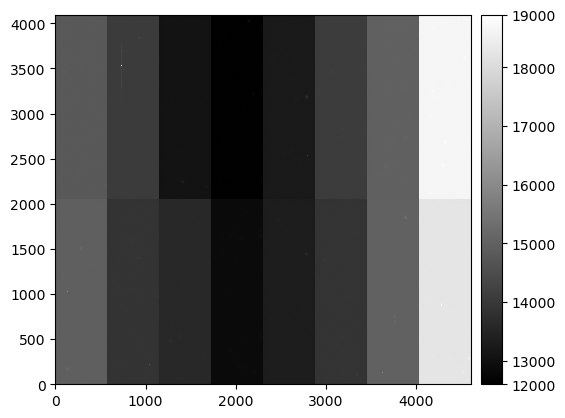

In [15]:
display2 = afwDisplay.Display(frame=1, backend='matplotlib')
display2.setMaskTransparency(90)
display2.scale("linear", "zscale")
display2.mtv(raw)

# Querying EFD Data
## Here's a recent example from Merlin

In [16]:
from lsst.summit.extras.slewTiming import plotExposureTiming
%matplotlib inline

from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, getTopics
client = makeEfdClient()

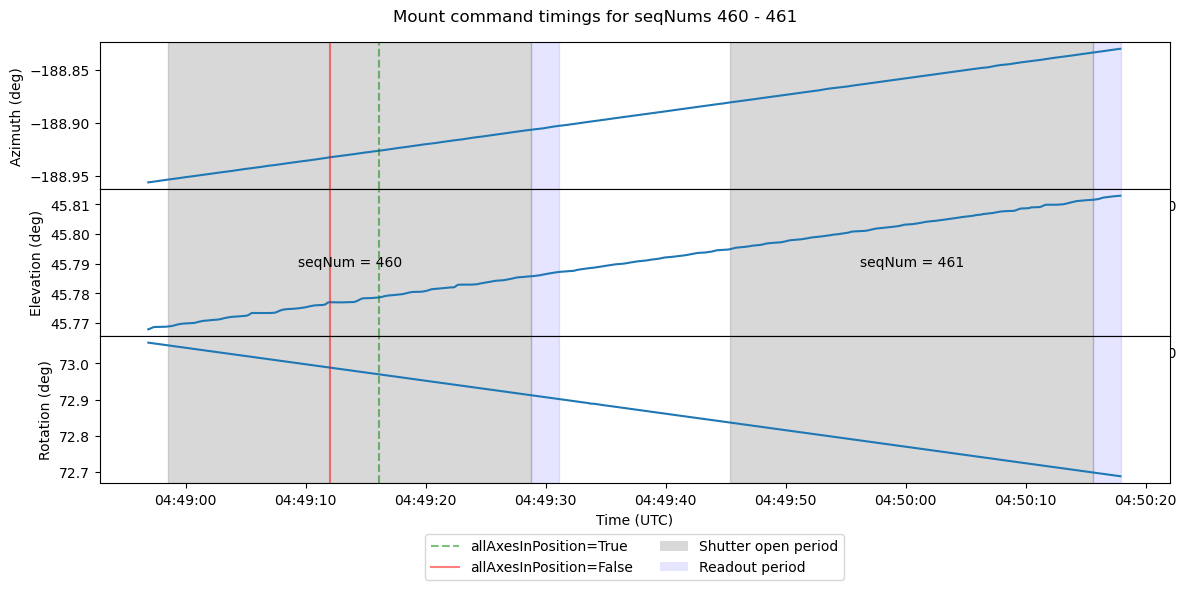

In [17]:
import warnings 
warnings.filterwarnings('ignore')
recordsToPlot = records[-2:]
fig = plotExposureTiming(client, recordsToPlot)

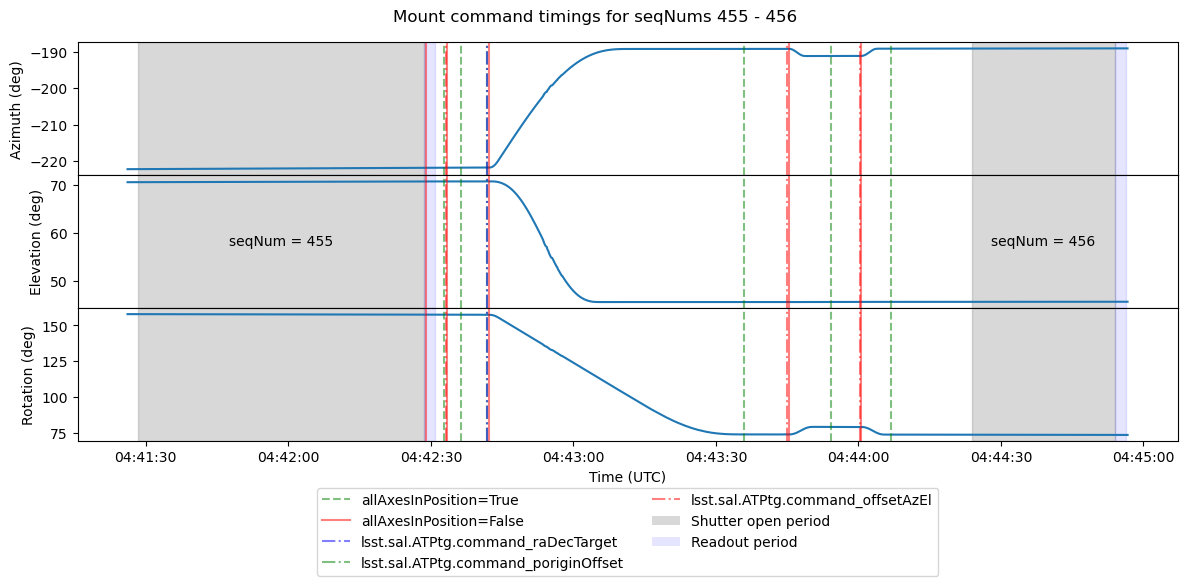

In [18]:
recordsToPlot = [r for r in records if r.seq_num in (455, 456)]
fig = plotExposureTiming(client, recordsToPlot)

In [19]:
records[-1]

exposure.RecordClass(instrument='LATISS', id=2024091000461, day_obs=20240910, group='2024-09-11T04:49:23.570', physical_filter='SDSSr_65mm~empty', obs_id='AT_O_20240910_000461', exposure_time=30.0, dark_time=30.2326, observation_type='science', observation_reason='imaging', seq_num=461, seq_start=461, seq_end=461, target_name='SMC_007', science_program='BLOCK-306', tracking_ra=13.66414818456269, tracking_dec=-73.17417766614422, sky_angle=359.99536700067927, azimuth=171.1826048345345, zenith_angle=44.24119670582736, has_simulated=False, can_see_sky=True, timespan=Timespan(begin=astropy.time.Time('2024-09-11 04:50:22.408015', scale='tai', format='iso'), end=astropy.time.Time('2024-09-11 04:50:52.640000', scale='tai', format='iso')))

In [20]:
getTopics(client, "*sal.ESS*")

['lsst.sal.ESS.accelerometer',
 'lsst.sal.ESS.accelerometerPSD',
 'lsst.sal.ESS.ackcmd',
 'lsst.sal.ESS.airFlow',
 'lsst.sal.ESS.airTurbulence',
 'lsst.sal.ESS.command_disable',
 'lsst.sal.ESS.command_enable',
 'lsst.sal.ESS.command_enterControl',
 'lsst.sal.ESS.command_exitControl',
 'lsst.sal.ESS.command_setLogLevel',
 'lsst.sal.ESS.command_standby',
 'lsst.sal.ESS.command_start',
 'lsst.sal.ESS.dewPoint',
 'lsst.sal.ESS.electricFieldStrength',
 'lsst.sal.ESS.hx85a',
 'lsst.sal.ESS.hx85ba',
 'lsst.sal.ESS.lightningStrikeStatus',
 'lsst.sal.ESS.logevent_appliedSettingsMatchStart',
 'lsst.sal.ESS.logevent_authList',
 'lsst.sal.ESS.logevent_configurationApplied',
 'lsst.sal.ESS.logevent_configurationsAvailable',
 'lsst.sal.ESS.logevent_errorCode',
 'lsst.sal.ESS.logevent_heartbeat',
 'lsst.sal.ESS.logevent_highElectricField',
 'lsst.sal.ESS.logevent_lightningStrike',
 'lsst.sal.ESS.logevent_logLevel',
 'lsst.sal.ESS.logevent_logMessage',
 'lsst.sal.ESS.logevent_precipitation',
 'lsst.sa

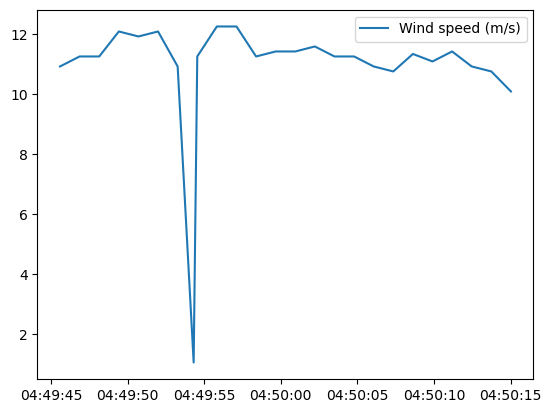

In [21]:
windData = getEfdData(client, 'lsst.sal.ESS.airFlow', expRecord=records[-1])
plt.plot(windData['speed'], label='Wind speed (m/s)')
plt.legend()

In [22]:
windData

,direction,directionStdDev,location,maxSpeed,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,salIndex,sensorName,speed,speedStdDev,timestamp
2024-09-11 04:49:45.585637+00:00,13.114591,2.033581,Weather tower,10.9254,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311685,1.726030e+09,301,Weather tower airflow,10.9254,0.000000,1.726030e+09
2024-09-11 04:49:46.866234+00:00,17.396931,4.252781,Weather tower,11.2590,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311686,1.726030e+09,301,Weather tower airflow,11.2590,0.247198,1.726030e+09
2024-09-11 04:49:48.146109+00:00,18.725058,2.507643,Weather tower,12.0930,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311687,1.726030e+09,301,Weather tower airflow,11.2590,0.000000,1.726030e+09
2024-09-11 04:49:49.426287+00:00,20.349133,3.180645,Weather tower,12.0930,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311688,1.726030e+09,301,Weather tower airflow,12.0930,0.370796,1.726030e+09
2024-09-11 04:49:50.705476+00:00,18.570019,1.590371,Weather tower,11.9262,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311689,1.726030e+09,301,Weather tower airflow,11.9262,0.247198,1.726030e+09
2024-09-11 04:49:51.985773+00:00,22.204903,2.014669,Weather tower,12.0930,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311690,1.726030e+09,301,Weather tower airflow,12.0930,0.030900,1.726030e+09
2024-09-11 04:49:53.266078+00:00,14.807454,3.831218,Weather tower,11.2590,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311691,1.726030e+09,301,Weather tower airflow,10.9254,0.000000,1.726030e+09
2024-09-11 04:49:54.311242+00:00,154.410355,8.801064,AT Dome,1.4400,1.726030e+09,ESS:204,1.726030e+09,424165,1.726030e+09,528165b1,27964,1.726030e+09,204,AuxTel-Windsonic,1.0450,0.172283,1.726030e+09
2024-09-11 04:49:54.546468+00:00,14.410042,0.761487,Weather tower,11.5926,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311692,1.726030e+09,301,Weather tower airflow,11.2590,0.247198,1.726030e+09
2024-09-11 04:49:55.825879+00:00,15.895003,0.457686,Weather tower,12.2598,1.726030e+09,ESS:301,1.726030e+09,424926,1.726030e+09,528165b1,1311693,1.726030e+09,301,Weather tower airflow,12.2598,0.494395,1.726030e+09


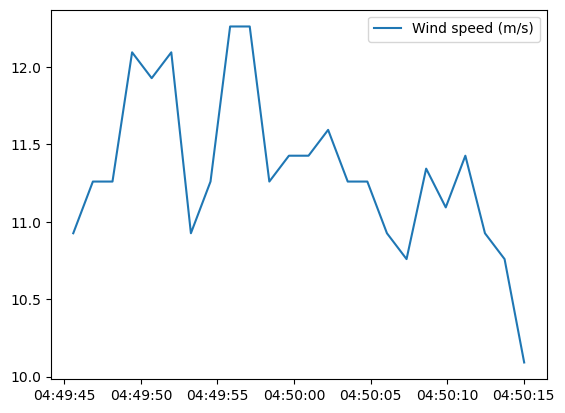

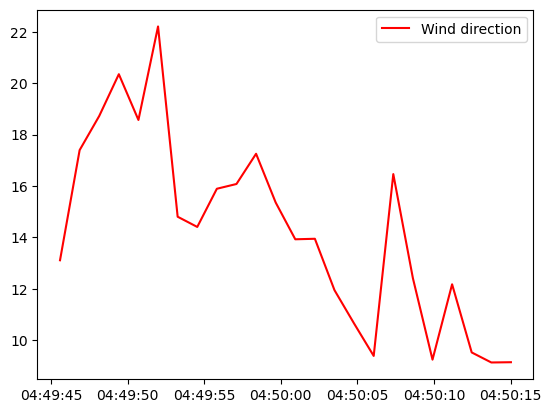

In [23]:
towerData = windData[windData['location']=='Weather tower']
plt.plot(towerData['speed'], label='Wind speed (m/s)')
plt.legend()
plt.show()  # new plot because direction might be out of scale for y-axis
plt.plot(towerData['direction'], label='Wind direction', c='r')
plt.legend()

Angelo has a great tutorial from the 2024 JTM: 
https://stanford.zoom.us/rec/share/Bpsn7k2LUu2T2ePhoS6KbL-H9V3ngjiASfI4xS_JqHRMuHzlQwYDgcaqvlb_qUV6.hqFtmsPZBX69lbE8?startTime=1707409792000